In [1]:
projectdir = "C:/Users/Arman Angaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia"
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, Interact, LsqFit, CSV, Blink, Pipe, ProgressMeter
pyplot()

include("Turnover/Turnover.jl")
include("Turnover/test.jl")
using .Turnover

import TumorGrowth
include("distribution_functions.jl")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-698645705626498575\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-11580009314202006902\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-698645705626498575\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

  Activating environment at `C:\Users\Arman Angaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`


Test Summary:             | Pass  Total
Applying turnover methods |    7      7


In [2]:
include("experimental_data/SeqDataFormatting.jl")
using .SeqDataFormatting

In [3]:
sampleinfo = TumorGrowth.data_import("experimental_data/wes_sampleinfo.csv", delim=",")
normal = "N1"
tumorsamples = sampleinfo.samplename
samples = [tumorsamples..., normal]

mutations_string = (DataFrame ∘ CSV.File)("experimental_data/DonateProcessed/Ling2015_pairwise_median.csv")
seqdata = SeqDataFormatting.string_to_seqresult(mutations_string, samples);

In [164]:
ccf_raw = seqdata_to_tumor(seqdata, sampleinfo; normal = "N1", 
    maxReadsNormal = 0, 
    minReads = 4,
    minCoverage = 15,
    maxCoverage = Inf,
    cnaAgreement = 22)
ccf_raw.frequencies = copy(ccf_raw.ccf);

In [201]:
mutnumb = 500

mutations = unique!(vcat(ccf_raw.mutations...))
subset = sample(mutations, min(mutnumb, length(mutations)), replace = false)

for sample in eachrow(ccf_raw)
    select = findall(m -> m in subset, sample.mutations)
    sample.mutations = copy(sample.mutations[select])
    sample.frequencies = copy(sample.frequencies[select])
    sample.vaf = copy(sample.vaf[select])
    sample.ccf = copy(sample.ccf[select])
    sample.reads = copy(sample.reads[select])
    sample.coverage = copy(sample.coverage[select])
end

LoadError: BoundsError: attempt to access 179-element Vector{Float64} at index [[2, 8, 9, 13, 15, 22, 25, 26, 28, 29  …  479, 482, 489, 498, 503, 508, 515, 517, 520, 526]]

In [181]:
# ccf_raw = TumorGrowth.data_import("experimental_data/DonateProcessed/CCFtumor.csv", delim=";");

In [200]:
ccf_raw = TumorGrowth.data_import("experimental_data/DonateProcessed/CCFtumor_strict.csv", delim=";");
ccf_raw.frequencies = ccf_raw.ccf;

In [192]:
ccf = deepcopy(ccf_raw);

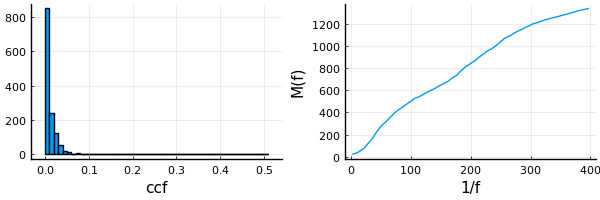

In [193]:
mtypes, mutations = TumorGrowth.clones_by_mutations(ccf; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(ccf) )
        end / mean(ccf.purity) )

res = 1/400
plot( 
    histogram(filter( f-> 0.8 > f > res, [freqs[m] for m=mutations]), nbins=50, lab="", xlab=:ccf),
    M(filter( f-> 0.8 > f > res, [freqs[m] for m=mutations]), nbins=50, lab=""),
    size=(600,200)
)

In [194]:
Nthresh = 200
res = 1/500

freqs = SeqDataFormatting.mfreqs(ccf) |> df -> Dict(df.mutation .=> df.frequency)
for row in eachrow(ccf)
    mask = row.frequencies .>= 1/3
    row.mutations = filter(m-> 0.8 > freqs[m] > res, row.mutations[mask])
end

htypes = unique(ccf.mutations)
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/Nthresh, htypes) ) )
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/Nthresh for m in muts), htypes) )

# get d
W_l = orphaned_red_treeless(orphaned_tumor) |>
        df -> sum(df.isorphaned)/sum(df.isgreen)

d_solve = min(1., 2*log(Nthresh)*W_l)

0.10896282501898275

In [195]:
1/(1-d_solve)

1.1222876307279817

In [196]:
# get mu

Ls = 0.1:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
        end )
    end

Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1, μ=mu*L, T=log(Nthresh)/(1-d_solve)))
    end
end

fitres = curve_fit(model, Ls, mean.(estranged_turnover), [0.5])
mu_fit = fitres.param[1]

0.9999940399006633

mean fit : 0.2125031986894415
averaged fits : 0.23523497245091163 ± 0.0029222090718015125


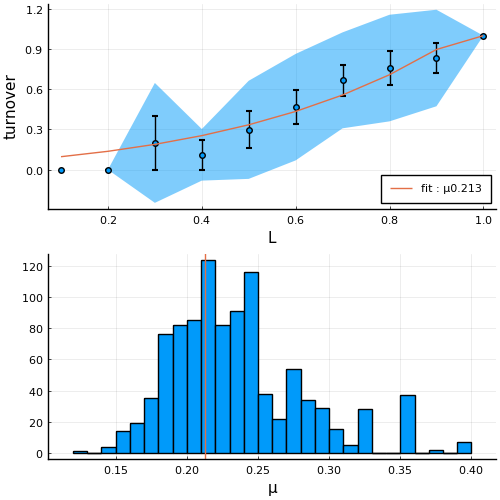

In [281]:
let d = d_solve
    t = estranged_turnover
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(Nthresh)/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [0.5])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright)
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [0.5]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(500,500))
end

In [52]:
function bisection(f, interval, iter; precision=1e-9)
    xlow, xup = interval
    sign(f(xlow)) == sign(f(xup)) && error("no zero in interval $interval")
    any((isnan.(f.(interval)))) && error("f not defined on interval $interval")
    for i=1:iter
        xm = (xlow+xup)/2
        abs(f(xm)) < precision && return (xm, i)
        if sign(f(xm)) != sign(f(xlow))
            xup = xm
        else
            xlow = xm
        end
    end
    println(xup)
    error("no convergence within $iter steps")
end

bisection (generic function with 1 method)

In [53]:
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)

mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(Nthresh)/(1-d_solve)))- W_c, [0.01,0.99], 100)
# mu_solve = fzero(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, 0.01, 0.99)

(0.20766241365112365, 31)

In [283]:
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)

mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(Nthresh)/(1-d_solve)))- W_c, [0.01,0.99], 100)
# mu_solve = fzero(mu -> min(1., W_estranged(d; b=b, μ=mu, T=log(Nthresh)/(b-d)))- W_c, 0.01, 0.99)

(0.5, 1)

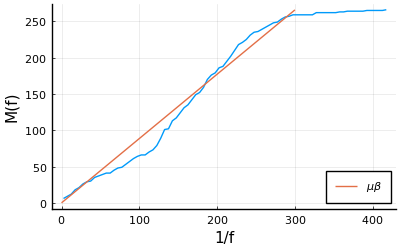

In [16]:
ccf = deepcopy(ccf_raw)
ccf.frequencies = ccf.ccf;

mtypes, mutations = TumorGrowth.clones_by_mutations(ccf; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(ccf) )
        end / mean(ccf.purity) )

M([freqs[m] for m=mutations], nbins=50, lab="", size=(400,250))
plot!(0:300, x-> x*mu_solve/(1-d_solve), lab=L"\mu \beta", legend=:bottomright)

In [21]:
println("q $(d_solve) | μ $(mu_solve)" )

q 0.63 | μ 0.327


> Filtersettings <br>
> - maxReadsNormal = 0
> - minReads = 4
> - minCoverage = 15
> - maxCoverage = 90
> - cnaAgreement = 22

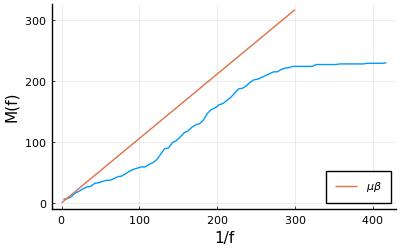

In [284]:
ccf = deepcopy(ccf_raw)

q, mu = d_solve, mu_fit

mtypes, mutations = TumorGrowth.clones_by_mutations(ccf; res=0.0);
freqs = Dict( mutations .=> map( mutations ) do m
    mean( m in cell.mutations ? cell.vaf[findfirst(isequal(m), cell.mutations)] : 0. for cell in eachrow(ccf) )
        end / mean(ccf.purity) )

M([freqs[m] for m=mutations], nbins=50, lab="", size=(400,250))
plot!(0:300, x-> x*mu/(1-q), lab=L"\mu \beta", legend=:bottomright)